In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Uncertainty in coordinates

In [4]:
import pandas as pd

fritz_phot = pd.read_csv("./Fritz_phot.csv")

ZTF_phot = fritz_phot[fritz_phot["instrument_name"] == "ZTF"]
ra, dec = ZTF_phot.ra, ZTF_phot.dec 
snr = ZTF_phot.snr

mean_ra, mean_dec = np.nansum(ra * snr) / np.nansum(snr), np.nansum(dec * snr) / np.nansum(snr)
var_ra = np.sum((ra - mean_ra)**2 * snr) / np.sum(snr)
var_dec = np.sum((dec - mean_dec)**2 * snr) / np.sum(snr)

((var_ra * np.cos(mean_dec * u.deg)**2 + var_dec)**.5 * u.deg).to("arcsec")

<Quantity 0.07728969 arcsec>

## Distance modulus

In [5]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [6]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

In [74]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=["time", "flux", "fluxerr", "mag", "mag_unc_u", "mag_unc_l", "lim", "band"],
)
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_uvw1 = joj_UVOT[joj_UVOT["band"] == "UW1"]
joj_UVOT_uvw2 = joj_UVOT[joj_UVOT["band"] == "UW2"]
joj_UVOT_uvm2 = joj_UVOT[joj_UVOT["band"] == "UM2"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT = pd.concat([joj_UVOT_b, joj_UVOT_v])
joj_UVOT

,time,flux,fluxerr,mag,mag_unc_u,mag_unc_l,lim,band
1,59716.367,1137.0,51.97,16.261,0.049,0.051,0.0,uvot::b
7,59720.061,1539.0,50.04,15.932,0.035,0.036,0.0,uvot::b
13,59720.459,1551.0,49.67,15.923,0.034,0.035,0.0,uvot::b
19,59722.745,1601.0,47.21,15.889,0.032,0.032,0.0,uvot::b
0,59716.372,1023.0,83.56,16.376,0.085,0.093,0.0,uvot::v
6,59720.065,1414.0,75.13,16.024,0.056,0.059,0.0,uvot::v
12,59720.462,1519.0,76.62,15.946,0.053,0.056,0.0,uvot::v
18,59722.750,1519.0,69.85,15.946,0.049,0.051,0.0,uvot::v


In [11]:
# ATLAS
joj_ATLAS = pd.read_csv("./atlas_forced_phot.txt", delimiter=" ", names=["MJD", "m", "dm", "uJy", "duJy", "F", "err", "chi/N", "RA", "Dec", "x", "y", "maj", "min", "phi", "apfit", "mag5sig", "Sky", "Obs"])
joj_ATLAS = np.loadtxt("./atlas_forced_phot.txt", dtype=object)
# joj_ATLAS = joj_ATLAS[:, [0, 2, 3, ]]
joj_ATLAS = joj_ATLAS[:, [0, 3, 4, 5]]
joj_ATLAS[:, :-1] = np.array(joj_ATLAS[:, :-1], dtype=float)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS[:, -1] == "o"]
arg = ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) <= 30) & ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) >= -8)
joj_ATLAS_o[:, -1] = "atlaso"
joj_ATLAS_o = joj_ATLAS_o[arg]
joj_ATLAS_o = pd.DataFrame(joj_ATLAS_o, columns=["time", "flux", "fluxerr", "band"])
joj_ATLAS_o

,time,flux,fluxerr,band
0,59716.484714,775.0,29.0,atlaso
1,59716.487913,810.0,31.0,atlaso
2,59716.493397,794.0,28.0,atlaso
3,59716.505247,808.0,31.0,atlaso
4,59719.19191,978.0,20.0,atlaso
...,...,...,...,...
75,59751.131495,441.0,256.0,atlaso
76,59754.316023,425.0,14.0,atlaso
77,59754.319246,398.0,14.0,atlaso
78,59754.329091,435.0,13.0,atlaso


## SALT3 fit

In [75]:
joj_SALT = {}
lc = joj_ZTF.copy()
arg = ((lc['MJD'] - t_max_mjd) / (1 + z) <= 20) & ((lc['MJD'] - t_max_mjd) / (1 + z) >= -10)
joj_SALT['time'] = lc['MJD'][arg]
joj_SALT['band'] = lc['passband'][arg]
joj_SALT['flux'] = lc['fnu_microJy'][arg]
joj_SALT['fluxerr'] = lc['fnu_microJy_unc'][arg]
joj_SALT = pd.concat([pd.DataFrame(joj_SALT), joj_UVOT, joj_ATLAS_o])

joj_SALT['zp'] = [2.5 * np.log10(3631 * 1e6)] * len(joj_SALT["time"])
joj_SALT['zpsys'] = ['ab'] * len(joj_SALT["time"])
# joj_SALT = Table(joj_SALT)

joj_SALT = Table(dict(joj_SALT))
# joj_SALT

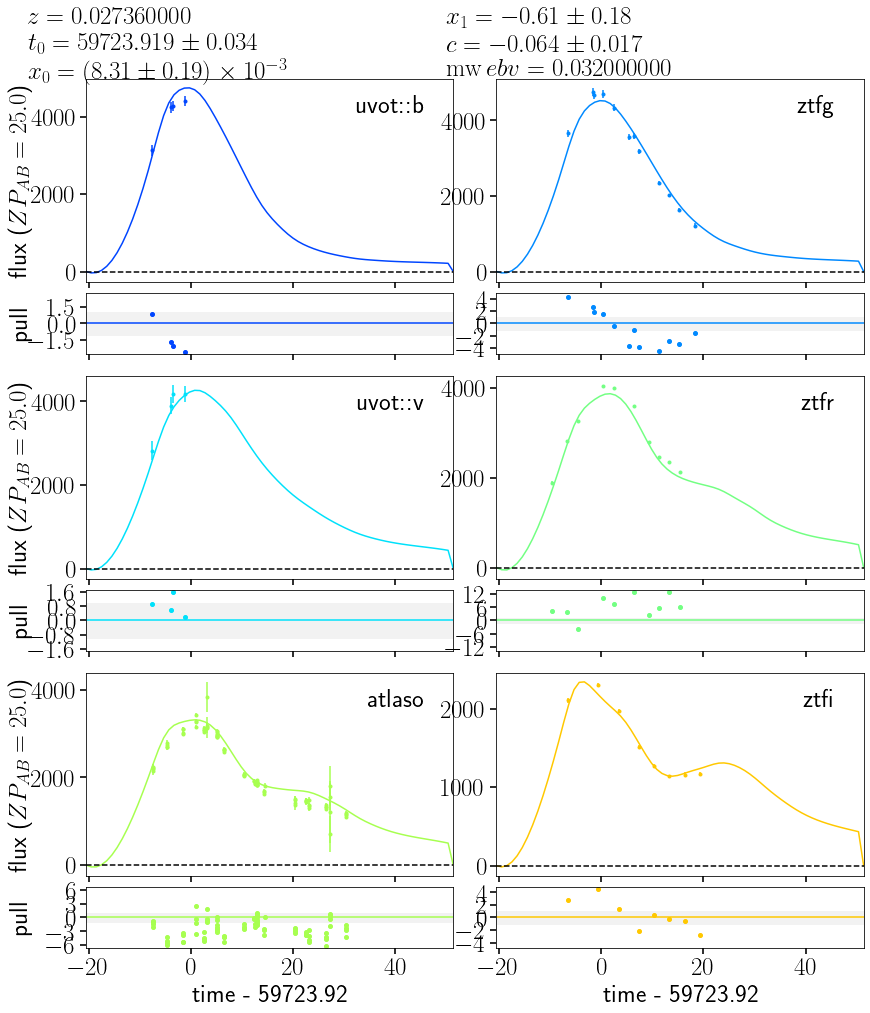

In [76]:
import sncosmo

model = sncosmo.Model(
    source="salt3",
    effects=[sncosmo.F99Dust()],
    effect_names=["mw"],
    effect_frames=["obs"],
)
model.set(z=z, mwebv=ebv)

np.random.seed(321)
result, fitted_model = sncosmo.mcmc_lc(
    joj_SALT, model, ["t0", "x0", "x1", "c"], nburn=1000, nsamples=500, thin=5
)

_ = sncosmo.plot_lc(joj_SALT, model=fitted_model, errors=result.errors, xfigsize=12)

In [77]:
leff_B = 4300
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
leff_uvot_u = 3523.78
leff_uvot_b = 4345.96
leff_uvot_v = 5412.38
leff_atlas_o = 6629.82
rv = 3.1
ebv = 0.032
from copy import deepcopy

samples = result.samples
sample_model = deepcopy(model)
t_max_s = np.empty((len(samples), 7))
m_max_s = np.empty((len(samples), 7))
for k, sample in enumerate(samples):
    sample_model.parameters[:] = np.append(np.append(z, sample), ebv)
    for j, (flt, leff) in enumerate(
        zip(
            ["bessellb", "ztfg", "ztfr", "ztfi", "atlaso", "uvot::b", "uvot::u"],
            [leff_B, leff_g, leff_r, leff_i, leff_atlas_o, leff_uvot_b, leff_uvot_u],
        )
    ):
        peakphase = sample_model.source.peakphase(flt)
        t_max_s[k, j] = peakphase * (1 + z) + sample[0]
        m_max_s[k, j] = (
            sample_model.source.bandmag(flt, "ab", peakphase)
            - mu
            - calALambda(wv=leff, RV=3.1, EBV=ebv)
        )

In [78]:
for j, (flt, leff) in enumerate(
    zip(
        ["bessellb", "ztfg", "ztfr", "ztfi", "atlaso", "uvot::b", "uvot::u"],
        [leff_B, leff_g, leff_r, leff_i, leff_atlas_o, leff_uvot_b, leff_uvot_u],
    )
):
    print(flt)
    t_max, t_max_lo, t_max_up = (
        np.percentile(t_max_s[:, j], 50),
        np.percentile(t_max_s[:, j], 16),
        np.percentile(t_max_s[:, j], 84),
    )
    m_max, m_max_lo, m_max_up = (
        np.percentile(m_max_s[:, j], 50),
        np.percentile(m_max_s[:, j], 16),
        np.percentile(m_max_s[:, j], 84),
    )
    print(
        "t_max (MJD) = {:.2f} + {:.2f} - {:.2f}".format(
            t_max, t_max_up - t_max, t_max - t_max_lo
        )
    )
    print(
        "M_max (mag) = {:.4f} + {:.4f} - {:.4f}".format(
            m_max, m_max_up - m_max, m_max - m_max_lo
        )
    )

t_max_mjd_B = 59723.1

bessellb
t_max (MJD) = 59723.40 + 0.03 - 0.03
M_max (mag) = -19.8029 + 0.0080 - 0.0112
ztfg
t_max (MJD) = 59724.21 + 0.04 - 0.03
M_max (mag) = -19.6781 + 0.0059 - 0.0084
ztfr
t_max (MJD) = 59725.29 + 0.03 - 0.03
M_max (mag) = -19.4065 + 0.0021 - 0.0020
ztfi
t_max (MJD) = 59720.42 + 0.05 - 0.04
M_max (mag) = -18.8693 + 0.0039 - 0.0037
atlaso
t_max (MJD) = 59724.20 + 0.04 - 0.05
M_max (mag) = -19.2372 + 0.0023 - 0.0022
uvot::b
t_max (MJD) = 59723.40 + 0.03 - 0.03
M_max (mag) = -19.8086 + 0.0080 - 0.0112
uvot::u
t_max (MJD) = 59720.64 + 0.05 - 0.04
M_max (mag) = -19.2349 + 0.0158 - 0.0206


## Color evolution

In [83]:
# From Bulla, Miller+2020

gr_population = pd.read_csv(
    "color/g_r_Bulla20.txt",
    delim_whitespace=True,
    comment="#",
    names=[
        "SN",
        "t",
        "e_t_min",
        "e_t_max",
        "gr",
        "e_gr_min",
        "e_gr_max",
        "type",
        "marker",
    ],
)

normal_ia = np.where(
    (gr_population.type == "normal*") | (gr_population.type == "normal")
)
over_luminous_ia = np.where(
    (gr_population.type == "91T-like")
    | (gr_population.type == "99aa-like")
    | (gr_population.type == "99aa-like*")
)

print(
    "There are {} normal SNe in this sample".format(
        len(gr_population.iloc[normal_ia].SN.unique())
    )
)

There are 56 normal SNe in this sample


In [84]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                        j += 1
                        continue
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [85]:
t_max_mjd_B = 59723.1
rise_time = 19.4615

# SN 2022joj
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
rv = 3.1
ebv = 0.032

t_fl_mjd = 59703.158
t_fl_mjd_lo, t_fl_mjd_up = 59702.583, 59703.855

t_exp = -(t_max_mjd_B - t_fl_mjd) / (1 + z)
t_exp_lo = -(t_max_mjd_B - t_fl_mjd_lo) / (1 + z)
t_exp_up = -(t_max_mjd_B - t_fl_mjd_up) / (1 + z)

g_r_cor = calALambda(leff_g, EBV=ebv, RV=rv) - calALambda(leff_r, EBV=ebv, RV=rv)
r_i_cor = calALambda(leff_r, EBV=ebv, RV=rv) - calALambda(leff_i, EBV=ebv, RV=rv)

ZTFg = np.array(
    [joj_ZTF_g["phase"], joj_ZTF_g["fnu_microJy"], joj_ZTF_g["fnu_microJy_unc"]]
).T
ZTFr = np.array(
    [joj_ZTF_r["phase"], joj_ZTF_r["fnu_microJy"], joj_ZTF_r["fnu_microJy_unc"]]
).T
ZTFi = np.array(
    [joj_ZTF_i["phase"], joj_ZTF_i["fnu_microJy"], joj_ZTF_i["fnu_microJy_unc"]]
).T

for lc in [ZTFg, ZTFr, ZTFi]:
    idx = lc[:, 1] < lc[:, 2] * 2
    lc[idx, 1] = lc[idx, 2] * 3
    lc[idx, 2] = 9999

phase_joj, g_r_joj, g_r_unc_joj = mag1_mag2(ZTFg, ZTFr, flux=True, bin_size=0.5)
g_r_joj = g_r_joj - g_r_cor
# print(phase_joj)
# K_corr = np.array([-0.1953523,  -0.18842639, -0.18842264, -0.17979563, -0.13118341, -0.07866182,
#  -0.07784923, -0.09957032, -0.14747028, -0.16704749, -0.18622967, -0.23207121,
#  -0.21986836, -0.21986175, -0.19807829, -0.19807533, -0.19169122, -0.18660783,
#  -0.17411484, -0.17234143, -0.16950744, -0.15789981])

In [86]:
# SN2011fe
g_fe = np.loadtxt("./SN2011fe/SN2011fe_g_synthetic.dat")
r_fe = np.loadtxt("./SN2011fe/SN2011fe_r_synthetic.dat")
g_r_fe = np.loadtxt("./SN2011fe/SN2011fe_g_r_synthetic.dat")

t_fl_fe = 55796.687
t_max_mjd_fe = 55814.5

distmod_fe = 29.04

In [87]:
# SN2013bh
with open("./SN2013bh/SN2013bh_lc.dat") as f:
    lines = f.readlines()

z_bh = float(lines[0].split("=")[-1])
ebv_bh = float(lines[1].split("=")[-1])
mu_bh = float(lines[2].split("=")[-1].split("+/-")[0])
t_max_mjd_bh = float(lines[3].split("=")[-1].split(")")[0])
mjd_bh = np.array([float(i) for i in lines[5].split()]) + 2456000 - 2400000.5
# phase_bh = (mjd_bh - t_max_mjd_bh) / (1 + z_bh)

t_fl_bh = (370.02 + 375.02) / 2 + 2456000 - 2400000.5
# phase_fl_bh = (mjd_bh - t_fl_bh) / (1 + z_bh)

dat = np.loadtxt("./SN2013bh/SN2013bh_lc_Kcorr.dat")
phase_bh = dat[:, 0]
g_bh, g_bh_err = dat[:, 1], dat[:, 3]
r_bh, r_bh_err = dat[:, 4], dat[:, 6]

g_r_bh = mag1_mag2(
    np.array([phase_bh, g_bh, g_bh_err]).T, np.array([phase_bh, r_bh, r_bh_err]).T
)

59701.380034700036 21.297784379266172
59702.26668980019 21.47711895878858
ZTF18abauprj over_luminous


14

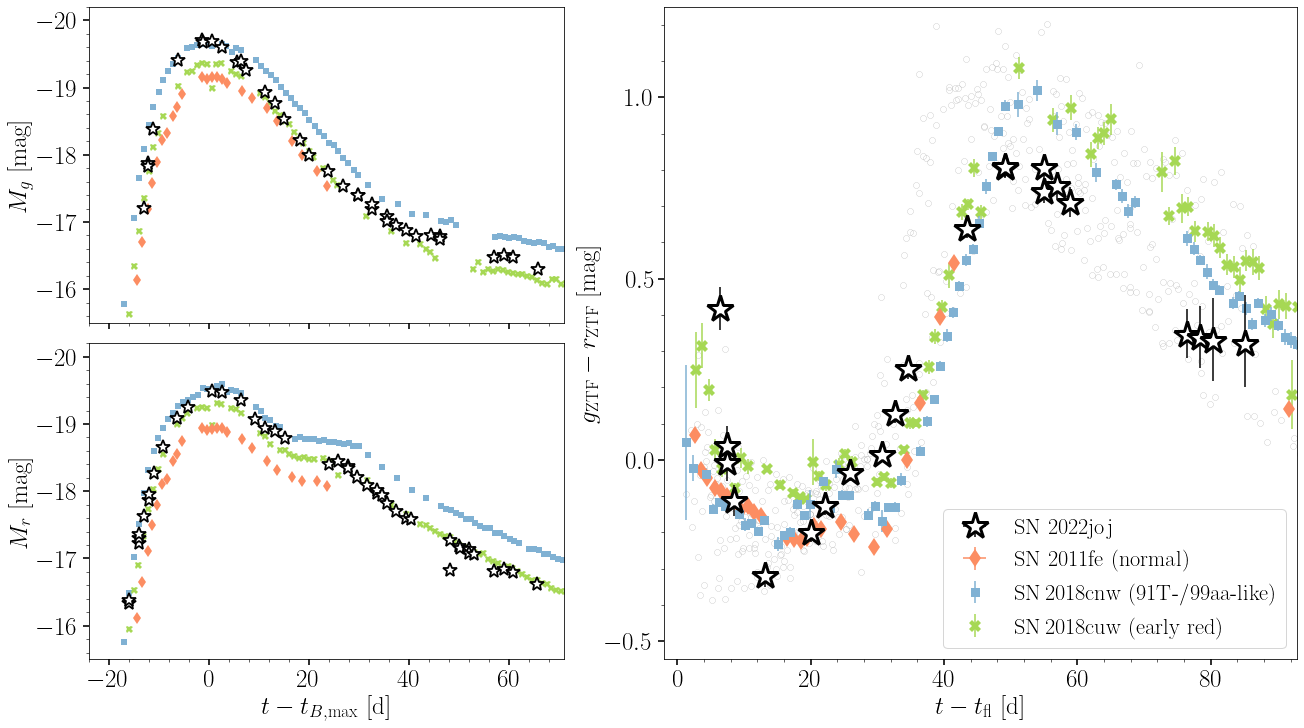

In [88]:
f = plt.figure(figsize=(18, 10), constrained_layout=True)
widths = [6, 8]
heights = [3.5, 3.5]
gs = f.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
# g light curves
ax1 = f.add_subplot(gs[0, 0])
# r light curves
ax2 = f.add_subplot(gs[1, 0])
# g - r
ax3 = f.add_subplot(gs[:, 1])

col_91T = color_map["blue"]
col_13bh = color_map["green1"]
col_11fe = color_map["orange"]

# 11fe
ax1.errorbar(
    (g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)
ax2.errorbar(
    (r_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)

# 13bh
# ax1.errorbar(
#     phase_bh,
#     g_bh,
#     yerr=g_bh_err,
#     fmt="p",
#     markersize=9,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
# )
# ax2.errorbar(
#     phase_bh,
#     r_bh,
#     yerr=r_bh_err,
#     fmt="p",
#     markersize=9,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
# )

for x, ax, leff in zip([joj_ZTF_g, joj_ZTF_r], [ax1, ax2], [leff_g, leff_r]):
    # last non-detection
    last_non_det = np.argwhere(
        (x["fnu_microJy"].values <= x["fnu_microJy_unc"].values * 2)
        & (x["phase"].values < -15)
    ).ravel()[-1]
    lim_non_det = -2.5 * np.log10(
        x["fnu_microJy_unc"].values[last_non_det] * 3 * 1e-6 / 3631
    )
    ax.arrow(
        x=x["phase"].values[last_non_det],
        y=lim_non_det - mu - calALambda(leff, RV=rv, EBV=ebv) - 0.3,
        dx=0,
        dy=0.3,
        width=0.08,
        head_width=1,
        head_length=0.1,
        length_includes_head=True,
        color="w",
    )
    print(x["MJD"].values[last_non_det], lim_non_det)
    ax.errorbar(
        x["phase"],
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=15,
        markeredgecolor="k",
        markeredgewidth=1.8,
        color="w",
    )

    ax.set_xlim(-24, 71)

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r"$M_g\ \mathrm{[mag]}$")
ax2.set_ylabel(r"$M_r\ \mathrm{[mag]}$")
ax2.set_xlabel(r"$t-t_{B,\mathrm{max}}\ [\mathrm{d}]$")

ax2.set_ylim(-20.2, -15.5)
ax1.set_ylim(-20.2, -15.5)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
ax3.errorbar(
    phase_joj + rise_time,
    g_r_joj,
    xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=28,
    markeredgecolor="k",
    markeredgewidth=3,
    color="w",
    ecolor="k",
    zorder=100,
    label="$\mathrm{SN\ 2022joj}$",
)
ax3.errorbar(
    (g_r_fe[:, 0] - t_fl_fe) / (1 + 0.0008),
    g_r_fe[:, 1],
    xerr=np.ones_like(g_r_fe[:, 0]) * 0.014,
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=13,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
    label="$\mathrm{SN\ 2011fe\ (normal)}$",
)

# peak time
# ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
#          color=col_22joj,
#          alpha=.9,
#          zorder=-10)

# ZTF sample
# K-corrections
# ax3.plot(
#     gr_population.iloc[normal_ia].t.values,
#     gr_population.iloc[normal_ia].gr.values,
#     "o",
#     color="None",
#     mec="0.4",
#     mew=0.3,
#     ms=6,
#     alpha=0.5,
# )
# ax3.plot(
#     gr_population.iloc[over_luminous_ia].t.values,
#     gr_population.iloc[over_luminous_ia].gr.values,
#     "s",
#     color="#80b1d3",
#     mec="k",
#     mew=0.5,
#     ms=6,
#     alpha=.5,
# )


# No K-corrections
ebv_sbv = pd.read_csv("./color/early18ia/ebv_sbv.txt", sep=" ")
lcs = glob.glob("./color/early18ia/*dat")
lcs.sort()
t_tfl_list = fits.getdata("./color/Bulla20.fit")

count = 0
for lc in lcs:
    name = lc.split("/")[-1].split(".")[0]
    if (name in gr_population.iloc[over_luminous_ia].SN.unique()) or (
        name in gr_population.iloc[normal_ia].SN.unique()
    ):
        t_tfl = t_tfl_list["t-tfl"][t_tfl_list["ZTF"] == name]
        if t_tfl_list["z"][t_tfl_list["ZTF"] == name] > 0.05:
            continue
        count += 1
        raw = pd.read_csv(lc, sep=" ")
        lc_g0 = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw["fid"] == 2]
        lc_g = np.array(raw)[:, :-1][
            (raw["fid"] == 1) & (raw["mag_unc"] < 0.2)
        ]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw["fid"] == 2) & (raw["mag_unc"] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0, bin_size=0.3)
        g_r = mag1_mag2(lc_g, lc_r, bin_size=0.3)
        t_offset = t_tfl - g_r0[0][0]
        ebv_obj = np.array(ebv_sbv["ebv"])[ebv_sbv["sn"] == name][0]
        if name == "ZTF18abcflnz":
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "X",
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=7,
            )
            ax3.errorbar(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="X",
                yerr=g_r[2],
                color=color_map["green2"],
                mec="0.2",
                mew=0,
                ms=12,
                label=r"$\mathrm{SN\,2018cuw\ (early\ red)}$",
                zorder=-1,
            )
        if name == "ZTF18abauprj":
            print(name, "over_luminous")
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax3.errorbar(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="s",
                yerr=g_r[2],
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=9,
                label=r"$\mathrm{SN\,2018cnw\ (91T}$-/$\mathrm{99aa}$-$\mathrm{like)}$"
                # label=r"$\mathrm{" + name + r"\ (91T}$-$\mathrm{like)}$",
            )
        else:
            ax3.plot(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                "o",
                color="None",
                mec="0.7",
                mew=0.3,
                ms=6,
                zorder=-10,
            )

# ax3.errorbar(
#     g_r_bh[0] + (t_max_mjd_bh - t_fl_bh) / (1 + z),
#     g_r_bh[1],
#     xerr=np.ones_like(g_r_bh[0]) * 2.5,
#     yerr=g_r_bh[2],
#     fmt="p",
#     markersize=15,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
#     label=r"$\mathrm{SN\ 2013bh\ (00cx}$-$\mathrm{like)}$",
# )
ax3.set_ylim(-0.55, 1.25)
ax3.set_xlim(-2, 93)
ax3.set_ylabel("$g_\mathrm{ZTF}-r_\mathrm{ZTF}\ \mathrm{[mag]}$")
ax3.set_xlabel("$t-t_\mathrm{fl}\ [\mathrm{d}]$")
# ax3.set_xscale("log")
ax3.legend(prop={"size": 22.5})

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax3.xaxis.set_major_locator(MultipleLocator(20))
ax3.xaxis.set_minor_locator(MultipleLocator(4))
ax3.yaxis.set_major_locator(MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

# xticks = [1, 2, 5, 10, 20, 40, 60, 100]
# ax3.set_xticks(xticks)
# ax3.set_xticklabels([f"${tick}$" for tick in xticks])

plt.savefig("../paper/figures/photometry.pdf", bbox_inches="tight")
count

59701.380034700036 21.297784379266172
59702.26668980019 21.47711895878858
ZTF18abauprj over_luminous
ZTF18abcflnz red
ZTF18abfhryc red


[Text(1, 0, '$1$'),
 Text(2, 0, '$2$'),
 Text(5, 0, '$5$'),
 Text(10, 0, '$10$'),
 Text(20, 0, '$20$'),
 Text(40, 0, '$40$'),
 Text(60, 0, '$60$'),
 Text(100, 0, '$100$')]

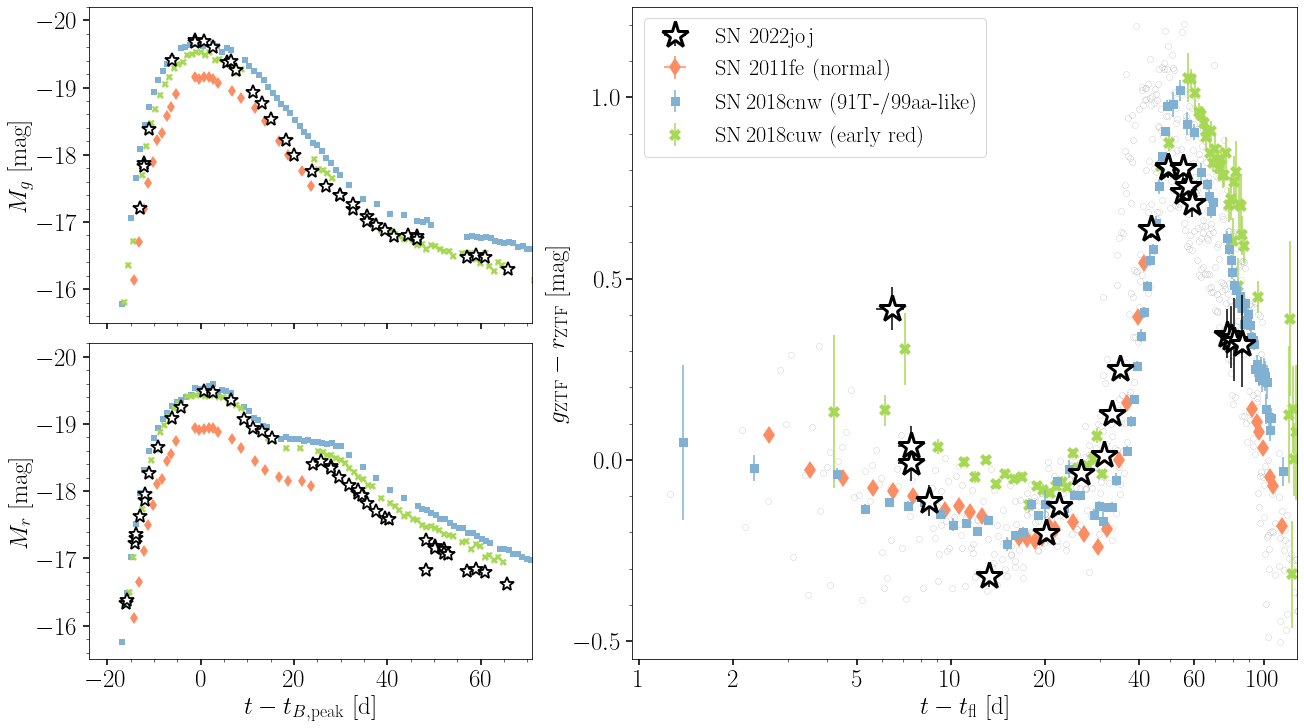

In [46]:
f = plt.figure(figsize=(18, 10), constrained_layout=True)
widths = [6, 9]
heights = [3.5, 3.5]
gs = f.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
# g light curves
ax1 = f.add_subplot(gs[0, 0])
# r light curves
ax2 = f.add_subplot(gs[1, 0])
# g - r
ax3 = f.add_subplot(gs[:, 1])

col_91T = color_map["blue"]
col_13bh = color_map["green1"]
col_11fe = color_map["orange"]

# 11fe
ax1.errorbar(
    (g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)
ax2.errorbar(
    (r_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
)

# 13bh
# ax1.errorbar(
#     phase_bh,
#     g_bh,
#     yerr=g_bh_err,
#     fmt="p",
#     markersize=9,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
# )
# ax2.errorbar(
#     phase_bh,
#     r_bh,
#     yerr=r_bh_err,
#     fmt="p",
#     markersize=9,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
# )

for x, ax, leff in zip([joj_ZTF_g, joj_ZTF_r], [ax1, ax2], [leff_g, leff_r]):
    # last non-detection
    last_non_det = np.argwhere(
        (x["fnu_microJy"].values <= x["fnu_microJy_unc"].values * 2)
        & (x["phase"].values < -15)
    ).ravel()[-1]
    lim_non_det = -2.5 * np.log10(
        x["fnu_microJy_unc"].values[last_non_det] * 3 * 1e-6 / 3631
    )
    ax.arrow(
        x=x["phase"].values[last_non_det],
        y=lim_non_det - mu - calALambda(leff, RV=rv, EBV=ebv) - 0.3,
        dx=0,
        dy=0.3,
        width=0.08,
        head_width=1,
        head_length=0.1,
        length_includes_head=True,
        color="w",
    )
    print(x["MJD"].values[last_non_det], lim_non_det)
    ax.errorbar(
        x["phase"],
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=15,
        markeredgecolor="k",
        markeredgewidth=1.8,
        color="w",
    )

    ax.set_xlim(-24, 71)

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r"$M_g\ \mathrm{[mag]}$")
ax2.set_ylabel(r"$M_r\ \mathrm{[mag]}$")
ax2.set_xlabel(r"$t-t_{B,\mathrm{peak}}\ [\mathrm{d}]$")

ax2.set_ylim(-20.2, -15.5)
ax1.set_ylim(-20.2, -15.5)
ax1.invert_yaxis()
ax2.invert_yaxis()

# g-r color
# the four individuals
ax3.errorbar(
    phase_joj + rise_time,
    g_r_joj,
    xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=28,
    markeredgecolor="k",
    markeredgewidth=3,
    color="w",
    ecolor="k",
    zorder=100,
    label="$\mathrm{SN\ 2022joj}$",
)
ax3.errorbar(
    (g_r_fe[:, 0] - t_fl_fe) / (1 + 0.0008),
    g_r_fe[:, 1],
    xerr=np.ones_like(g_r_fe[:, 0]) * 0.014,
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=13,
    markeredgecolor="k",
    markeredgewidth=0,
    color=col_11fe,
    label="$\mathrm{SN\ 2011fe\ (normal)}$",
)

# peak time
# ax3.plot([(tp - tfl) / (1 + z), (tp - tfl) / (1 + z)], [-0.7, -0.4],
#          color=col_22joj,
#          alpha=.9,
#          zorder=-10)

# ZTF sample
# K-corrections
# ax3.plot(
#     gr_population.iloc[normal_ia].t.values,
#     gr_population.iloc[normal_ia].gr.values,
#     "o",
#     color="None",
#     mec="0.4",
#     mew=0.3,
#     ms=6,
#     alpha=0.5,
# )
# ax3.plot(
#     gr_population.iloc[over_luminous_ia].t.values,
#     gr_population.iloc[over_luminous_ia].gr.values,
#     "s",
#     color="#80b1d3",
#     mec="k",
#     mew=0.5,
#     ms=6,
#     alpha=.5,
# )


# No K-corrections
ebv_sbv = pd.read_csv("./color/early18ia/ebv_sbv.txt", sep=" ")
lcs = glob.glob("./color/early18ia/*dat")
lcs.sort()
t_tfl_list = fits.getdata("./color/Bulla20.fit")

count = 0
for lc in lcs:
    name = lc.split("/")[-1].split(".")[0]
    if (name in gr_population.iloc[over_luminous_ia].SN.unique()) or (
        name in gr_population.iloc[normal_ia].SN.unique()
    ):
        t_tfl = t_tfl_list["t-tfl"][t_tfl_list["ZTF"] == name]
        if t_tfl_list["z"][t_tfl_list["ZTF"] == name] > 0.05:
            continue
        count += 1
        raw = pd.read_csv(lc, sep=" ")
        lc_g0 = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection
        lc_r0 = np.array(raw)[:, :-1][raw["fid"] == 2]
        lc_g = np.array(raw)[:, :-1][
            (raw["fid"] == 1) & (raw["mag_unc"] < 0.2)
        ]  # SNR > 5
        lc_r = np.array(raw)[:, :-1][(raw["fid"] == 2) & (raw["mag_unc"] < 0.2)]
        g_r0 = mag1_mag2(lc_g0, lc_r0, bin_size=0.3)
        g_r = mag1_mag2(lc_g, lc_r, bin_size=0.3)
        t_offset = t_tfl - g_r0[0][0]
        ebv_obj = np.array(ebv_sbv["ebv"])[ebv_sbv["sn"] == name][0]
        if np.max(g_r[1][g_r[0] + t_offset < 10]) - (
            calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
            - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
        ) > 0.3:
            print(name, "red")
            if name != "ZTF18abcflnz":
                ax1.plot(
                    lc_g0[:, 0],
                    lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                    "X",
                    color=color_map["green2"],
                    mec="0.2",
                    mew=0,
                    ms=7,
                )
                ax2.plot(
                    lc_r0[:, 0],
                    lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                    "X",
                    color=color_map["green2"],
                    mec="0.2",
                    mew=0,
                    ms=7,
                )
                ax3.errorbar(
                    g_r[0] + t_offset,
                    g_r[1]
                    - (
                        calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                        - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                    ),
                    fmt="X",
                    yerr=g_r[2],
                    color=color_map["green2"],
                    mec="0.2",
                    mew=0,
                    ms=12,
                    label=r"$\mathrm{SN\,2018cuw\ (early\ red)}$",
                    zorder=-1,
                )
        if name == "ZTF18abauprj":
            print(name, "over_luminous")
            ax1.plot(
                lc_g0[:, 0],
                lc_g0[:, 1] - calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax2.plot(
                lc_r0[:, 0],
                lc_r0[:, 1] - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1),
                "s",
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=6,
            )
            ax3.errorbar(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                fmt="s",
                yerr=g_r[2],
                color="#80b1d3",
                mec="0.2",
                mew=0,
                ms=9,
                label=r"$\mathrm{SN\,2018cnw\ (91T}$-/$\mathrm{99aa}$-$\mathrm{like)}$"
                # label=r"$\mathrm{" + name + r"\ (91T}$-$\mathrm{like)}$",
            )
        else:
            ax3.plot(
                g_r[0] + t_offset,
                g_r[1]
                - (
                    calALambda(wv=leff_g, EBV=ebv_obj, RV=3.1)
                    - calALambda(wv=leff_r, EBV=ebv_obj, RV=3.1)
                ),
                "o",
                color="None",
                mec="0.7",
                mew=0.3,
                ms=6,
                zorder=-10,
            )

# ax3.errorbar(
#     g_r_bh[0] + (t_max_mjd_bh - t_fl_bh) / (1 + z),
#     g_r_bh[1],
#     xerr=np.ones_like(g_r_bh[0]) * 2.5,
#     yerr=g_r_bh[2],
#     fmt="p",
#     markersize=15,
#     markeredgecolor="k",
#     markeredgewidth=0,
#     color=col_13bh,
#     label=r"$\mathrm{SN\ 2013bh\ (00cx}$-$\mathrm{like)}$",
# )
ax3.set_ylim(-0.55, 1.25)
ax3.set_xlim(0.95, 128)
ax3.set_ylabel("$g_\mathrm{ZTF}-r_\mathrm{ZTF}\ \mathrm{[mag]}$")
ax3.set_xlabel("$t-t_\mathrm{fl}\ [\mathrm{d}]$")
ax3.set_xscale("log")
ax3.legend(prop={"size": 22.5})

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_locator(MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

xticks = [1, 2, 5, 10, 20, 40, 60, 100]
ax3.set_xticks(xticks)
ax3.set_xticklabels([f"${tick}$" for tick in xticks])

# plt.savefig("../paper/figures/photometry.pdf", bbox_inches="tight")

14

Text(0.5, 1.0, '$r$')

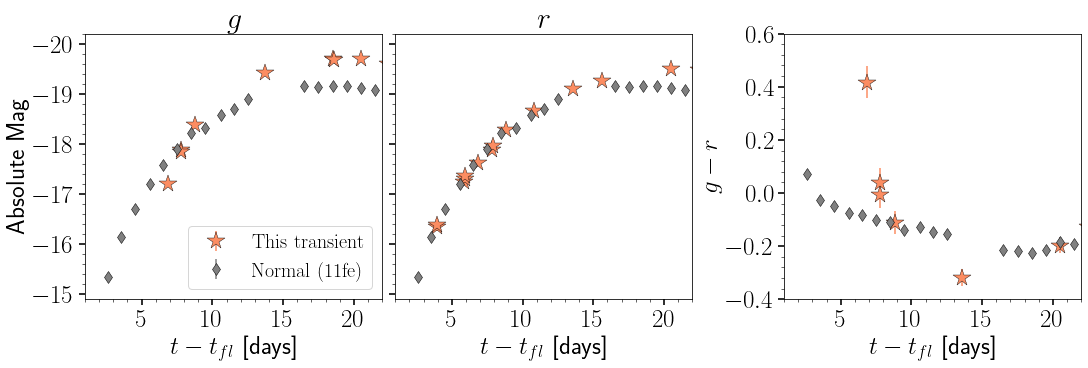

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharex=True)

col_22joj = color_map["orange"]

for x, a, leff in zip([joj_ZTF_g, joj_ZTF_r], ax, [leff_g, leff_r]):
    a.errorbar(
        x["phase"] + rise_time,
        x["mag"] - mu - calALambda(leff, RV=rv, EBV=ebv),
        # xerr=[[t_fl_mjd_up - t_fl_mjd], [t_fl_mjd - t_fl_mjd_lo]],
        yerr=np.array([x["mag_err_l"].values, x["mag_err_u"].values]),
        fmt="*",
        markersize=18,
        markeredgecolor="k",
        markeredgewidth=0.4,
        color=col_22joj,
        label="$\mathrm{This\ transient}$",
    )
    a.set_ylim(-14.9, -20.2)

    a.xaxis.set_major_locator(MultipleLocator(5))
    a.xaxis.set_minor_locator(MultipleLocator(1))
    a.yaxis.set_major_locator(MultipleLocator(1))
    a.yaxis.set_minor_locator(MultipleLocator(0.2))

ax[1].set_yticklabels([])
ax[2].set_ylabel(r"$g-r$")
ax[2].errorbar(
    phase_joj + rise_time,
    g_r_joj,
    yerr=g_r_unc_joj,
    fmt="*",
    markersize=18,
    markeredgecolor="k",
    markeredgewidth=0.4,
    color=col_22joj,
)


ax[0].errorbar(
    (g_fe[:, 0] - t_fl_fe) / (1 + 0.0008),
    g_fe[:, 1] - distmod_fe,
    yerr=g_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
    label="$\mathrm{Normal\ (11fe)}$",
)
ax[1].errorbar(
    (r_fe[:, 0] - t_fl_fe) / (1 + 0.000804),
    r_fe[:, 1] - distmod_fe,
    yerr=r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
)
ax[2].errorbar(
    (g_r_fe[:, 0] - t_fl_fe) / (1 + 0.000804),
    g_r_fe[:, 1],
    yerr=g_r_fe[:, 2],
    fmt="d",
    markersize=9,
    markeredgecolor="k",
    markeredgewidth=0.5,
    color="0.5",
)
ax[0].set_xlim(1, 22)
ax[0].legend(prop={"size": 20})


ax[2].set_ylim(-0.4, 0.6)
ax[2].yaxis.set_major_locator(MultipleLocator(0.2))
ax[2].yaxis.set_minor_locator(MultipleLocator(0.04))

ax[0].set_xlabel(r"$t - t_{fl}$ [days]")
ax[1].set_xlabel(r"$t - t_{fl}$ [days]")
ax[2].set_xlabel(r"$t - t_{fl}$ [days]")
ax[0].set_ylabel(r"Absolute Mag")

ax[0].set_title("$g$")
ax[1].set_title("$r$")